In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import glob
import torchvision.io
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
class LipReadingDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None, fixed_frame_count=29, max_classes=500):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))[:max_classes]
        self.files = []
        self.fixed_frame_count = fixed_frame_count
        
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls, phase)
            for file in os.listdir(class_dir):
                if file.endswith('.mp4'):
                    self.files.append((os.path.join(class_dir, file), cls))
        
        print(f"Found {len(self.files)} videos across {len(self.classes)} classes.")
        if len(self.files) == 0:
            print("No videos found. Please check the dataset directory structure and paths.")
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        video_path, label = self.files[idx]
        frames = self.load_video(video_path)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        label = self.classes.index(label)
        frames = torch.stack(frames)
        
        return frames, label
    
    def load_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        cap.release()
        return frames

In [3]:
# Function to split the dataset
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])

# Function to get predictions and true labels
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            accuracy = accuracy_score(all_labels, all_preds)

    return accuracy, all_preds, all_labels

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()

def plot_loss(train_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.show()
    
def plot_acc(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Plot')
    plt.legend()
    plt.grid(True)

    plt.show()

In [4]:
def collate_fn(batch):
    videos, labels = zip(*batch)
    padded_videos = []
    for video in videos:
        resized_video = torch.stack([resize(frame, (128, 128)) for frame in video])
        padded_videos.append(resized_video[5:25])
        
    return torch.stack(padded_videos).permute(0,2,1,3,4), torch.tensor(labels)

In [5]:
# Path to the processed_selected_mp4_files directory
root_dir = '/Users/Zachary/Documents/Courses/ECE228/project/preprocessed_25'  # Update this path

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_val_dataset = LipReadingDataset(root_dir, 'train', transform=transform, max_classes=25)
train_dataset, val_dataset = split_dataset(train_val_dataset, train_ratio=0.8)
test_dataset = LipReadingDataset(root_dir, 'test', transform=transform, max_classes=25)


cuda:0
Found 5000 videos across 25 classes.
Found 1225 videos across 25 classes.


In [6]:
class CNN3D(nn.Module):
    def __init__(self, num_classes):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 512, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_loss = []
    val_acc = []
    train_acc = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        all_labels = []
        all_preds = []

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        avg_loss = epoch_loss / len(train_loader)
        train_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracy, _, _ = evaluate_model(model, val_loader, device)

        train_loss.append(avg_loss)
        val_acc.append(val_accuracy)
        train_acc.append(train_accuracy)

        scheduler.step()
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}, Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            
    return train_loss, train_acc, val_acc

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=lambda x: collate_fn(x))
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, collate_fn=lambda x: collate_fn(x))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x))

num_classes = len(train_val_dataset.classes)  # Automatically get the number of classes
learning_rate = 0.0001
num_epochs = 20

model = CNN3D(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_loss, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000099, Epoch [1/20], Avg Loss: 3.2211, Train Accuracy: 0.0435, Validation Accuracy: 0.0300


Epoch 2/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000098, Epoch [2/20], Avg Loss: 3.2202, Train Accuracy: 0.0418, Validation Accuracy: 0.0410


Epoch 3/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000095, Epoch [3/20], Avg Loss: 3.2084, Train Accuracy: 0.0628, Validation Accuracy: 0.0770


Epoch 4/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000090, Epoch [4/20], Avg Loss: 3.0089, Train Accuracy: 0.1148, Validation Accuracy: 0.1670


Epoch 5/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000085, Epoch [5/20], Avg Loss: 2.6698, Train Accuracy: 0.1928, Validation Accuracy: 0.3150


Epoch 6/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000079, Epoch [6/20], Avg Loss: 2.3892, Train Accuracy: 0.2660, Validation Accuracy: 0.3480


Epoch 7/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000073, Epoch [7/20], Avg Loss: 2.1788, Train Accuracy: 0.3262, Validation Accuracy: 0.4140


Epoch 8/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000065, Epoch [8/20], Avg Loss: 1.9968, Train Accuracy: 0.3725, Validation Accuracy: 0.4380


Epoch 9/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000058, Epoch [9/20], Avg Loss: 1.8536, Train Accuracy: 0.4098, Validation Accuracy: 0.4790


Epoch 10/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000050, Epoch [10/20], Avg Loss: 1.7194, Train Accuracy: 0.4392, Validation Accuracy: 0.4870


Epoch 11/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000042, Epoch [11/20], Avg Loss: 1.5963, Train Accuracy: 0.4938, Validation Accuracy: 0.5000


Epoch 12/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000035, Epoch [12/20], Avg Loss: 1.4999, Train Accuracy: 0.5225, Validation Accuracy: 0.5030


Epoch 13/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000027, Epoch [13/20], Avg Loss: 1.4092, Train Accuracy: 0.5480, Validation Accuracy: 0.5200


Epoch 14/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000021, Epoch [14/20], Avg Loss: 1.3396, Train Accuracy: 0.5733, Validation Accuracy: 0.5330


Epoch 15/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000015, Epoch [15/20], Avg Loss: 1.2876, Train Accuracy: 0.5895, Validation Accuracy: 0.5300


Epoch 16/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000010, Epoch [16/20], Avg Loss: 1.2264, Train Accuracy: 0.6178, Validation Accuracy: 0.5300


Epoch 17/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000005, Epoch [17/20], Avg Loss: 1.1944, Train Accuracy: 0.6182, Validation Accuracy: 0.5390


Epoch 18/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000002, Epoch [18/20], Avg Loss: 1.1971, Train Accuracy: 0.6180, Validation Accuracy: 0.5350


Epoch 19/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000001, Epoch [19/20], Avg Loss: 1.1619, Train Accuracy: 0.6362, Validation Accuracy: 0.5370


Epoch 20/20:   0%|          | 0/400 [00:00<?, ?batch/s]

Learning Rate: 0.000000, Epoch [20/20], Avg Loss: 1.1566, Train Accuracy: 0.6322, Validation Accuracy: 0.5340


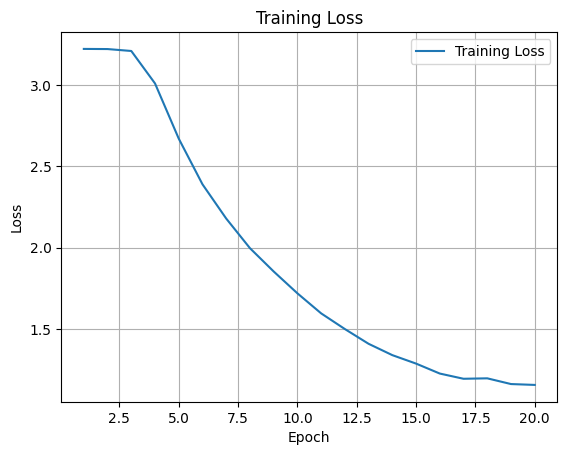

In [8]:
# plot training losses
plot_loss(train_loss)

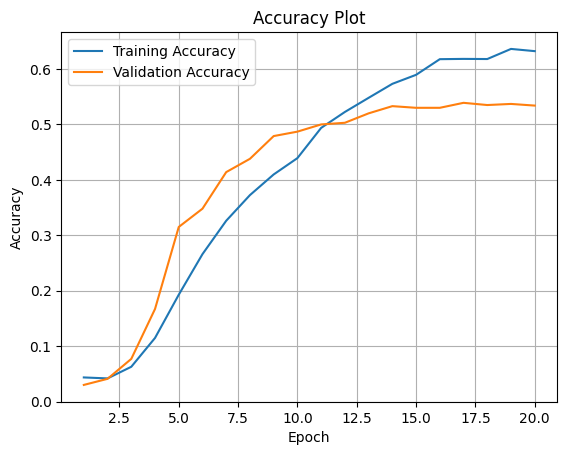

In [9]:
plot_acc(train_acc, val_acc)

Accuracy: 0.5404081632653062


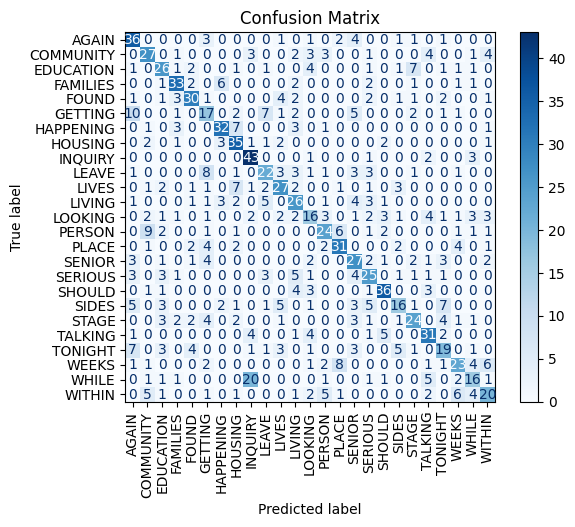

In [10]:
# Assuming the model is already trained and the dataloaders are defined
accuracy, pred_labels, true_labels = evaluate_model(model, test_loader, device)
print(f'Accuracy: {accuracy}')
# Plot confusion matrix
plot_confusion_matrix(true_labels, pred_labels, train_val_dataset.classes)